# 第三次讀書會
**第二組**
主題模型

## 主題模型

套件<br>
資料前處理<br>
lexicon-based 的主題模型<br>
LDA 主題模型<br>
視覺化主題模型<br>
GuidedLDA<br>
主題模型的應用

## Word2Vec相關方法

## 1. 套件載入

In [ ]:
import time
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 設定中文字體
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

## 2. 資料前處理

此次資料來源是工作流程系統的中國時報、自由時報、東森新聞、蘋果日報的政治版，3/1到4/1的新聞，由於目標是尋找政治版中的前在主題，故未設定篩選字與排除字。

metadata:新聞篇數以及需求前處理<br>

中國時報:共4854篇；無記者，內文不須整理。<br>
東森新聞:共567篇；無記者，內文不須整理。<br>
蘋果日報:共1640篇；需要移除頭尾記者資訊、廣告資訊。

In [ ]:
#載入所有資料
apple = pd.read_csv("raw_data/蘋果政治_24.csv")
chinatime = pd.read_csv("raw_data/中時政治_24.csv")
#freetime = pd.read_csv("raw_data/自由時報政治_34.csv")
eastforest = pd.read_csv("raw_data/東森政治_24.csv")


# 資料筆數
num_rows = len(apple),len(chinatime),len(eastforest)
print(num_rows)


apple.head(3)

(1640, 4854, 567)


,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,游錫堃敗選請辭立委！ 韓國瑜：願把院長辦公室讓給他,2024-02-01 13:59:00,政治,https://tw.nextapple.com/politics/20240201/002...,【記者蘇柏銓、潘袁詩羽／台北報導】立法院第11屆新科立委今報到，並投票選出立法院正副院長。稍...,appleDaily
1,2,陳昭姿「廢票原因」太難信 黃光芹：真是個「很低級X3」的錯誤,2024-02-01 16:40:00,政治,https://tw.nextapple.com/politics/20240201/01F...,【許潔如／綜合報導】立法院長龍頭戰，民眾黨立委陳昭姿雖遵循黨意投給黨內立委黃珊珊，但印泥不小...,appleDaily
2,3,立法院遇到韓國瑜要說什麼 黃捷淡淡一句！她最在意這件事,2024-02-01 10:12:00,政治,https://tw.nextapple.com/politics/20240201/084...,第11屆立委今天報到，民進黨立委黃捷被問到想對國民黨立委韓國瑜說什麼，她回應，過去就過去了，...,appleDaily


In [ ]:
chinatime.head()

,system_id,dataSource,artUrl,artDate,artTitle,artContent
0,1,chinatimes,https://www.chinatimes.com/realtimenews/202404...,2024-04-01 22:04:29,綠營國會改革縮了？他貼野百合學運文宣諷：別當看門狗,民進黨近日提出本會期國會改革法案，被發現與過往提出的2016年版本相比大為限縮，缺少罰鍰與限...
1,2,chinatimes,https://www.chinatimes.com/realtimenews/202404...,2024-04-01 23:04:04,接見AIT理事主席羅森伯格 夏立言：持續深化台美關係,趕在準總統賴清德520就職前，美國在台協會（AIT）主席羅森伯格在大選後再度來訪，國民黨副主...
2,3,chinatimes,https://www.chinatimes.com/realtimenews/202404...,2024-04-01 19:04:31,虎尾鎮長補選「藍白合」？ 柯拍片支持藍營林嘉弘,雲林縣虎尾鎮長補選將於13日投開票，近日民眾黨主席柯文哲錄製影片支持國民黨徵召的林嘉弘，被外...
3,4,chinatimes,https://www.chinatimes.com/realtimenews/202404...,2024-04-01 22:04:04,寶林廚師手驗出米酵菌酸 她讚北市府：採到唯一關鍵證據,寶林茶室食物中毒致死案持續調查真相，台北市府今(2日)召開記者會，指衛生局3月24日於寶林茶...
4,5,chinatimes,https://www.chinatimes.com/realtimenews/202404...,2024-04-01 21:04:53,金防部「對海實彈射擊改至陸上靶場」因憂兩岸緊繃？ 軍方揭原委,兩岸近期在金門海域情勢緊繃，陸軍金門防衛指揮部（金防部）今（2）日原預定進行對海實彈射擊，但...


In [ ]:
eastforest.head()

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,立院龍頭戰／民眾黨黃珊珊少一票 疑蓋章不正確成「廢票」｜東森新聞,https://news.ebc.net.tw/news/article/403447,2024-02-01 11:34:00,政治,2月1日舉行的「第11屆立法院院長」選舉，過半門檻為57票，第一輪投票韓國瑜獲得54票，游錫...,EBC
1,2,立院龍頭戰／紅毯迎新科立委 準藍委黃仁搶頭香｜東森新聞,https://news.ebc.net.tw/news/article/403541,2024-02-01 07:28:00,政治,第十一屆「立法委員當選人」今（1）日就職，國民黨準立委黃仁搶頭香先在議場門口擺上了自己的人形...,EBC
2,3,立院龍頭戰／謝龍介帶「賴清德雨傘」：一生監督你一人｜東森新聞,https://news.ebc.net.tw/news/article/403549,2024-02-01 08:34:00,政治,今天是新科立委報到日，同時也是立法院正副院長選舉，立法院新兵報到，最重要的一個環節之一，就是...,EBC
3,4,立院龍頭戰／正副院長今揭曉！3黨決勝負 投票流程曝｜東森新聞,https://news.ebc.net.tw/news/article/403550,2024-02-01 08:57:00,政治,立法院第11屆新科立委今（1）日上任，立法院正副院長選舉也將一同舉行，並分別在上午及下午投開...,EBC
4,5,名人森論題》鏡論／八堂會審拷禿牛｜東森新聞,https://news.ebc.net.tw/news/article/403555,2024-02-01 09:10:00,政治,民眾黨出了四道申論題，要藍、綠兩黨立法院院長、副院長候選人上門應考闖口試關卡。此舉擺明了就是...,EBC


### 2.1 資料前處理-蘋果
新增記者欄位<br>
移除廣告與記者資訊

In [ ]:
#蘋果新聞資料前處理
import pandas as pd
import re

# 定義處理函數
def apple_process_content(row):
    content = row['artContent']
    journalist = None

    # 尋找並提取記者名稱，並移除記者名稱和報導標籤
    journalist_match = re.search(r"【(.*?)／", content)
    if journalist_match:
        journalist = journalist_match.group(1)
        # 移除記者名稱和報導標籤部分
        content = re.sub(r"【.*?報導】", "", content)

    # 移除爆料網址後的所有文字
    content = re.sub(r"爆料網址：.*", "", content)

    return pd.Series([journalist, content])

In [ ]:
# 應用處理函數，並創建新欄位
apple[['journalist', 'artContent']] = apple.apply(apple_process_content, axis=1)

apple.head()

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource,journalist
0,1,游錫堃敗選請辭立委！ 韓國瑜：願把院長辦公室讓給他,2024-02-01 13:59:00,政治,https://tw.nextapple.com/politics/20240201/002...,立法院第11屆新科立委今報到，並投票選出立法院正副院長。稍早立法院長選舉結果出爐，確定由國民...,appleDaily,記者蘇柏銓、潘袁詩羽
1,2,陳昭姿「廢票原因」太難信 黃光芹：真是個「很低級X3」的錯誤,2024-02-01 16:40:00,政治,https://tw.nextapple.com/politics/20240201/01F...,立法院長龍頭戰，民眾黨立委陳昭姿雖遵循黨意投給黨內立委黃珊珊，但印泥不小心沾染到其他立委框格...,appleDaily,許潔如
2,3,立法院遇到韓國瑜要說什麼 黃捷淡淡一句！她最在意這件事,2024-02-01 10:12:00,政治,https://tw.nextapple.com/politics/20240201/084...,第11屆立委今天報到，民進黨立委黃捷被問到想對國民黨立委韓國瑜說什麼，她回應，過去就過去了，...,appleDaily,None
3,4,陳昭姿蓋章出包成廢票！ 民眾黨中評會要查了,2024-02-01 18:12:00,政治,https://tw.nextapple.com/politics/20240201/0D6...,立法院正副院長選舉落幕，掌握八席的民眾黨在上午院長、下午副院長選舉採取相同策略，第一輪分別投...,appleDaily,記者施智齡
4,5,「韓江配」出爐！江啟臣當選副院長 攜手韓國瑜掌舵立院,2024-02-01 17:09:00,政治,https://tw.nextapple.com/politics/20240201/11A...,立法院第11屆新科立委今天正式報到宣誓，並進行立法院正副院長選舉，院長選舉確定由國民黨立委韓...,appleDaily,記者蘇柏銓、潘袁詩羽、施智齡


### 2.2將三個來源依照欄位[artDate, artTitle, artContent]合併

In [ ]:
# 確保所有DataFrame包含需要的欄位
columns_needed = ['artDate', 'artTitle', 'artContent','artUrl']

# 合併三個資料集
merged_df = pd.concat([apple[columns_needed], chinatime[columns_needed], eastforest[columns_needed]], ignore_index=True)

print(len(merged_df))
merged_df.head()

7061


,artDate,artTitle,artContent,artUrl
0,2024-02-01 13:59:00,游錫堃敗選請辭立委！ 韓國瑜：願把院長辦公室讓給他,立法院第11屆新科立委今報到，並投票選出立法院正副院長。稍早立法院長選舉結果出爐，確定由國民...,https://tw.nextapple.com/politics/20240201/002...
1,2024-02-01 16:40:00,陳昭姿「廢票原因」太難信 黃光芹：真是個「很低級X3」的錯誤,立法院長龍頭戰，民眾黨立委陳昭姿雖遵循黨意投給黨內立委黃珊珊，但印泥不小心沾染到其他立委框格...,https://tw.nextapple.com/politics/20240201/01F...
2,2024-02-01 10:12:00,立法院遇到韓國瑜要說什麼 黃捷淡淡一句！她最在意這件事,第11屆立委今天報到，民進黨立委黃捷被問到想對國民黨立委韓國瑜說什麼，她回應，過去就過去了，...,https://tw.nextapple.com/politics/20240201/084...
3,2024-02-01 18:12:00,陳昭姿蓋章出包成廢票！ 民眾黨中評會要查了,立法院正副院長選舉落幕，掌握八席的民眾黨在上午院長、下午副院長選舉採取相同策略，第一輪分別投...,https://tw.nextapple.com/politics/20240201/0D6...
4,2024-02-01 17:09:00,「韓江配」出爐！江啟臣當選副院長 攜手韓國瑜掌舵立院,立法院第11屆新科立委今天正式報到宣誓，並進行立法院正副院長選舉，院長選舉確定由國民黨立委韓...,https://tw.nextapple.com/politics/20240201/11A...


In [ ]:
#基礎資料清理
def clean_dataframe(df):
    # 刪除URL
    df["artContent"] = df["artContent"].str.replace("(http|https)://.*", "", regex=True)
    df["artTitle"] = df["artTitle"].str.replace("(http|https)://.*", "", regex=True)

    # 保留中文字符
    df["artContent"] = df["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
    df["artTitle"] = df["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

    # 創建一個新的列'content'，其實只是'artContent'的一個重命名
    df['content'] = df['artContent']

    df = df.loc[:,["content", "artUrl",  'artDate']]

    return df  # 返回清理後的DataFrame

In [ ]:
df_clean = clean_dataframe(merged_df)

In [ ]:
df_clean.head()

,content,artUrl,artDate
0,立法院第屆新科立委今報到並投票選出立法院正副院長稍早立法院長選舉結果出爐確定由國民黨立委韓國...,https://tw.nextapple.com/politics/20240201/002...,2024-02-01 13:59:00
1,立法院長龍頭戰民眾黨立委陳昭姿雖遵循黨意投給黨內立委黃珊珊但印泥不小心沾染到其他立委框格被臨...,https://tw.nextapple.com/politics/20240201/01F...,2024-02-01 16:40:00
2,第屆立委今天報到民進黨立委黃捷被問到想對國民黨立委韓國瑜說什麼她回應過去就過去了接下來就好好...,https://tw.nextapple.com/politics/20240201/084...,2024-02-01 10:12:00
3,立法院正副院長選舉落幕掌握八席的民眾黨在上午院長下午副院長選舉採取相同策略第一輪分別投黨內立...,https://tw.nextapple.com/politics/20240201/0D6...,2024-02-01 18:12:00
4,立法院第屆新科立委今天正式報到宣誓並進行立法院正副院長選舉院長選舉確定由國民黨立委韓國瑜以票...,https://tw.nextapple.com/politics/20240201/11A...,2024-02-01 17:09:00


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

df_clean["words"] = df_clean["content"].apply(getToken)


df_clean.head()

Building prefix dict from c:\Users\User\Desktop\Python\2024碩士\Social media analys\study group3\dict\dict.txt.big ...
2024-05-01 12:03:05,993 : DEBUG : Building prefix dict from c:\Users\User\Desktop\Python\2024碩士\Social media analys\study group3\dict\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u3ab59d6ee3c5f4b311613d447f2a31bf.cache
2024-05-01 12:03:05,994 : DEBUG : Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u3ab59d6ee3c5f4b311613d447f2a31bf.cache
Loading model cost 0.879 seconds.
2024-05-01 12:03:06,871 : DEBUG : Loading model cost 0.879 seconds.
Prefix dict has been built successfully.
2024-05-01 12:03:06,873 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artDate,words
0,立法院第屆新科立委今報到並投票選出立法院正副院長稍早立法院長選舉結果出爐確定由國民黨立委韓國...,https://tw.nextapple.com/politics/20240201/002...,2024-02-01 13:59:00,"[立法院, 第屆, 新科, 立委, 報到, 投票, 選出, 立法院, 正副, 院長, 稍早,..."
1,立法院長龍頭戰民眾黨立委陳昭姿雖遵循黨意投給黨內立委黃珊珊但印泥不小心沾染到其他立委框格被臨...,https://tw.nextapple.com/politics/20240201/01F...,2024-02-01 16:40:00,"[立法, 院長, 龍頭, 戰民眾, 黨立委, 昭姿, 遵循, 黨意, 投給, 黨內, 立委,..."
2,第屆立委今天報到民進黨立委黃捷被問到想對國民黨立委韓國瑜說什麼她回應過去就過去了接下來就好好...,https://tw.nextapple.com/politics/20240201/084...,2024-02-01 10:12:00,"[第屆, 立委, 今天, 報到, 民進黨, 立委, 問到, 國民黨, 立委, 韓國, 回應,..."
3,立法院正副院長選舉落幕掌握八席的民眾黨在上午院長下午副院長選舉採取相同策略第一輪分別投黨內立...,https://tw.nextapple.com/politics/20240201/0D6...,2024-02-01 18:12:00,"[立法院, 正副, 院長, 選舉, 落幕, 掌握, 八席, 民眾, 上午, 院長, 下午, ..."
4,立法院第屆新科立委今天正式報到宣誓並進行立法院正副院長選舉院長選舉確定由國民黨立委韓國瑜以票...,https://tw.nextapple.com/politics/20240201/11A...,2024-02-01 17:09:00,"[立法院, 第屆, 新科, 立委, 今天, 正式, 報到, 宣誓, 進行, 立法院, 正副,..."


## 3.人工給定主題
我們的資料是採用不同新聞網的政治板，想看模型能自己找出什麼樣的主題

## 4. LDA主題模型

In [ ]:
docs = df_clean['words'].to_list()
print(len(docs))

docs[0][:50]

7061


['立法院',
 '第屆',
 '新科',
 '立委',
 '報到',
 '投票',
 '選出',
 '立法院',
 '正副',
 '院長',
 '稍早',
 '立法',
 '院長',
 '選舉',
 '出爐',
 '確定',
 '國民黨',
 '立委',
 '韓國',
 '出任',
 '立法院',
 '院長',
 '落選',
 '民進黨',
 '立委',
 '游錫堃則',
 '宣布',
 '請辭',
 '立委',
 '韓國',
 '致詞',
 '時向',
 '游錫堃',
 '致上',
 '最高',
 '謝意',
 '並稱',
 '過去',
 '台灣',
 '民主',
 '貢獻',
 '有目共睹',
 '未來',
 '重要',
 '國會',
 '外交',
 '希望',
 '一起',
 '院長',
 '辦公室']

In [ ]:
dictionary = Dictionary(docs)
# 篩掉出現少於5個文件的詞跟出現超過99%的詞
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-01 12:03:43,101 : INFO : adding document #0 to Dictionary<0 unique tokens: []>


2024-05-01 12:03:43,895 : INFO : built Dictionary<81663 unique tokens: ['一起', '一路', '並稱', '他江', '付出']...> from 7061 documents (total 1348449 corpus positions)
2024-05-01 12:03:43,896 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<81663 unique tokens: ['一起', '一路', '並稱', '他江', '付出']...> from 7061 documents (total 1348449 corpus positions)", 'datetime': '2024-05-01T12:03:43.896337', 'gensim': '4.3.0', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}
2024-05-01 12:03:43,944 : INFO : discarding 62665 tokens: [('他江', 1), ('炯炯', 2), ('煥然一新', 3), ('眾藍委', 1), ('給游錫堃', 4), ('責任重大', 4), ('三遍', 2), ('付之一炬', 1), ('個票', 1), ('動刀', 2)]...
2024-05-01 12:03:43,945 : INFO : keeping 18998 tokens which were in no less than 5 and no more than 6990 (=99.0%) documents
2024-05-01 12:03:43,971 : INFO : resulting dictionary: Dictionary<18998 unique tokens: ['一起', '一路', '並稱', '付

Dictionary<18998 unique tokens: ['一起', '一路', '並稱', '付出', '使用']...>


In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一起: 0
一路: 1
並稱: 2
付出: 3
使用: 4
兩位: 5
出任: 6
出爐: 7
創造: 8
努力: 9
台灣: 10
合作: 11


In [ ]:
pprint(" ".join(df_clean['words'].iloc[600]))

('助理 爆料 假面 甜心 北市 議員 林穎孟 查出 前男友 葉曜彰 詐領 助理 萬元 兩人 貪污 治罪 條例 起訴 先前 檢方 偵辦 期間 諭令 萬元 '
 '交保 台北 地院 今天下午 再次 開庭 法官 告知 林穎孟 保釋金 具保 人林致 光聲 退還 晚點 前若 拿不出 覓保 收押 了解 林致 前誠泰 銀行 '
 '少東 前年 林穎孟 秘婚 兩人 婚變 閃離林 男才 法院 聲請 保釋金 法院 今天下午 開庭 林穎 孟葉曜彰 出庭 依舊 否認 犯行 庭上 法官 詢問 '
 '雙方 傳喚 證人 排定 未來 審理 期程庭末 諭知 全案 核辦 法官 突然 葉曜彰 先行 離去 並將 林穎孟 留下 表示 事情 需要 確認 法官 告訴 '
 '林穎孟 保釋金 具保 人林致 光聲 退還 要求 林穎 孟今 晚點 交出 萬元 將依有 逃亡 之虞 收押 林穎孟 律師 抗議 太倉促 一時 出錢 法官 '
 '指林致 光有 告訴 法院 林穎孟 名下 房子 林穎孟 隨即 回應 家人 買給 房產 房貸 希望 替代 方案 法官 理會 諭知 退庭 林穎 孟則 候審 '
 '留置 了解 原先 幫林穎孟 具保 林致 光年 男友 身分 為林穎 孟辦 秘密 登記 結婚 去年底 疑似 情變 離婚 林致 光才 法院 聲請 退保')


In [ ]:
dictionary.doc2bow(df_clean['words'].iloc[600])[:10]

[(22, 1),
 (39, 1),
 (140, 1),
 (184, 1),
 (211, 1),
 (222, 1),
 (241, 1),
 (389, 1),
 (395, 1),
 (424, 1)]

In [ ]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
type(corpus)

list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [ ]:
ldamodel = LdaModel(
    corpus=corpus,
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2024-05-01 12:11:53,395 : INFO : using symmetric alpha at 0.1
2024-05-01 12:11:53,396 : INFO : using symmetric eta at 0.1
2024-05-01 12:11:53,399 : INFO : using serial LDA version on this node
2024-05-01 12:11:53,415 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 7061 documents, updating model once every 2000 documents, evaluating perplexity every 7061 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-01 12:11:53,416 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-01 12:11:53,417 : INFO : PROGRESS: pass 0, at document #2000/7061
2024-05-01 12:11:54,236 : INFO : merging changes from 2000 documents into a model of 7061 documents
2024-05-01 12:11:54,247 : INFO : topic #5 (0.100): 0.016*"民進黨" + 0.012*"國民黨" + 0.010*"表示" + 0.010*"立委" + 0.010*"立法院" + 0.010*"黨團" + 0.009*"民眾" + 0.007*"韓國" + 0.007*"院長" + 0.005*"質詢"
2024-05-01 12

In [ ]:
ldamodel.print_topics()

2024-05-01 12:12:12,594 : INFO : topic #0 (0.100): 0.012*"市長" + 0.010*"台灣" + 0.009*"表示" + 0.008*"總統" + 0.005*"新北" + 0.005*"未來" + 0.005*"合作" + 0.005*"台北" + 0.004*"美國" + 0.004*"持續"
2024-05-01 12:12:12,595 : INFO : topic #1 (0.100): 0.015*"台灣" + 0.007*"總統" + 0.007*"表示" + 0.006*"民主" + 0.005*"國民黨" + 0.005*"民進黨" + 0.005*"國家" + 0.004*"立委" + 0.004*"政府" + 0.004*"指出"
2024-05-01 12:12:12,596 : INFO : topic #2 (0.100): 0.011*"大陸" + 0.010*"柯文" + 0.009*"表示" + 0.009*"台灣" + 0.007*"金門" + 0.007*"海巡" + 0.007*"兩岸" + 0.006*"中國" + 0.005*"民進黨" + 0.005*"海域"
2024-05-01 12:12:12,597 : INFO : topic #3 (0.100): 0.011*"電價" + 0.008*"政府" + 0.008*"表示" + 0.007*"台灣" + 0.007*"政策" + 0.005*"民進黨" + 0.005*"產業" + 0.004*"調整" + 0.004*"調漲" + 0.004*"總統"
2024-05-01 12:12:12,599 : INFO : topic #4 (0.100): 0.013*"立委" + 0.012*"國民黨" + 0.012*"民進黨" + 0.008*"立法院" + 0.007*"表示" + 0.007*"投票" + 0.007*"謝國" + 0.006*"國會" + 0.006*"韓國" + 0.006*"市長"
2024-05-01 12:12:12,600 : INFO : topic #5 (0.100): 0.019*"民進黨" + 0.018*"國民黨" + 0.017*"立委" + 0.014*

[(0,
  '0.012*"市長" + 0.010*"台灣" + 0.009*"表示" + 0.008*"總統" + 0.005*"新北" + 0.005*"未來" + 0.005*"合作" + 0.005*"台北" + 0.004*"美國" + 0.004*"持續"'),
 (1,
  '0.015*"台灣" + 0.007*"總統" + 0.007*"表示" + 0.006*"民主" + 0.005*"國民黨" + 0.005*"民進黨" + 0.005*"國家" + 0.004*"立委" + 0.004*"政府" + 0.004*"指出"'),
 (2,
  '0.011*"大陸" + 0.010*"柯文" + 0.009*"表示" + 0.009*"台灣" + 0.007*"金門" + 0.007*"海巡" + 0.007*"兩岸" + 0.006*"中國" + 0.005*"民進黨" + 0.005*"海域"'),
 (3,
  '0.011*"電價" + 0.008*"政府" + 0.008*"表示" + 0.007*"台灣" + 0.007*"政策" + 0.005*"民進黨" + 0.005*"產業" + 0.004*"調整" + 0.004*"調漲" + 0.004*"總統"'),
 (4,
  '0.013*"立委" + 0.012*"國民黨" + 0.012*"民進黨" + 0.008*"立法院" + 0.007*"表示" + 0.007*"投票" + 0.007*"謝國" + 0.006*"國會" + 0.006*"韓國" + 0.006*"市長"'),
 (5,
  '0.019*"民進黨" + 0.018*"國民黨" + 0.017*"立委" + 0.014*"民眾" + 0.012*"院長" + 0.011*"立法院" + 0.010*"黨團" + 0.009*"表示" + 0.008*"韓國" + 0.007*"柯文"'),
 (6,
  '0.006*"海巡" + 0.006*"相關" + 0.006*"表示" + 0.006*"市府" + 0.006*"事件" + 0.006*"政府" + 0.005*"台北市" + 0.005*"管碧玲" + 0.004*"指出" + 0.004*"中央"'),
 (7,
  '0.011*"

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：未來發展
+ 主題二：國內政治
+ 主題三：兩岸關係與海巡
+ 主題四：電價主張
+ ...
+ 主題十：陳建仁相關質詢

In [ ]:
#看每篇文章的主題分佈 (`theta`)
ldamodel.get_document_topics(corpus[1])


[(5, 0.88722754), (7, 0.104668275)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。


perplexity = -8.298256709998387<br>
2**-perplexity = 314.7923584973923<br>
PMI score = 0.024265372521706154 (介於-1~1)

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-01 12:12:56,644 : INFO : -8.298 per-word bound, 314.8 perplexity estimate based on a held-out corpus of 7061 documents with 1228901 words


-8.298256709998387

In [ ]:
np.exp2(-perplexity)

314.7923584973923

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-05-01 12:13:14,959 : INFO : using ParallelWordOccurrenceAccumulator<processes=15, batch_size=64> to estimate probabilities from sliding windows
2024-05-01 12:13:27,065 : INFO : 1 batches submitted to accumulate stats from 64 documents (11007 virtual)
2024-05-01 12:13:27,067 : INFO : 2 batches submitted to accumulate stats from 128 documents (23570 virtual)
2024-05-01 12:13:27,069 : INFO : 3 batches submitted to accumulate stats from 192 documents (37747 virtual)
2024-05-01 12:13:27,072 : INFO : 4 batches submitted to accumulate stats from 256 documents (50193 virtual)
2024-05-01 12:13:27,075 : INFO : 5 batches submitted to accumulate stats from 320 documents (61894 virtual)
2024-05-01 12:13:27,077 : INFO : 6 batches submitted to accumulate stats from 384 documents (73917 virtual)
2024-05-01 12:13:27,080 : INFO : 7 batches submitted to accumulate stats from 448 documents (85530 virtual)
2024-05-01 12:13:27,083 : INFO : 8 batches submitted to accumulate stats from 512 documents (988

這個主題的 PMI score:  0.024265372521706154


In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[0.022948354460265614,
 0.009500717370082002,
 -0.03662954610977468,
 -0.012133218171032656,
 0.01543247206179201,
 0.08117059353020217,
 -0.0031837810612466715,
 0.012502292057506416,
 0.11437144290088963,
 0.03867439817837772]

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 1~9 來做分析。

In [ ]:
t0 = time.time()

topic_num_list = np.arange(1, 9)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")


2024-05-01 12:17:51,556 : INFO : using symmetric alpha at 0.5
2024-05-01 12:17:51,557 : INFO : using symmetric eta at 0.5
2024-05-01 12:17:51,560 : INFO : using serial LDA version on this node
2024-05-01 12:17:51,565 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 7061 documents, updating model once every 2000 documents, evaluating perplexity every 7061 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-01 12:17:51,566 : INFO : PROGRESS: pass 0, at document #2000/7061
2024-05-01 12:17:52,345 : INFO : merging changes from 2000 documents into a model of 7061 documents
2024-05-01 12:17:52,347 : INFO : topic #0 (0.500): 0.009*"表示" + 0.009*"民進黨" + 0.009*"國民黨" + 0.007*"立委" + 0.006*"立法院" + 0.006*"黨團" + 0.006*"民眾" + 0.005*"台灣" + 0.005*"今天" + 0.004*"院長"
2024-05-01 12:17:52,347 : INFO : topic #1 (0.500): 0.009*"立委" + 0.009*"民進黨" + 0.007*"表示" + 0.007*"國民黨" + 0.006*"台灣" + 0.006*"立法院" + 0.005*"質詢" + 0.005*"韓國" + 0.004*"院長" + 0

花費時間: 240.0289602279663 sec


In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,4029.826865,0.015287
1,3,3680.857882,0.026944
2,4,3464.768062,0.040610
3,5,3322.258662,0.031093
4,6,3233.770465,0.027774
5,7,3172.330343,0.038488
6,8,3168.640899,0.030698
7,9,3113.542688,0.049664


<Axes: xlabel='topic_num'>

2024-05-01 12:22:01,364 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:01,373 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:01,375 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:01,376 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:01,376 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:01,377 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:01,378 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

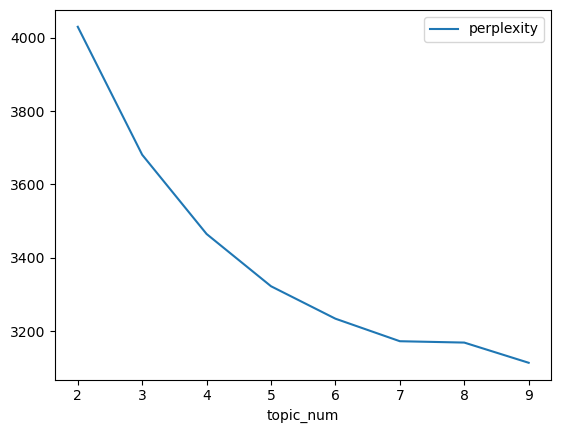

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

2024-05-01 12:22:16,370 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:16,372 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:16,374 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:16,374 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:16,375 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:16,377 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:22:16,378 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

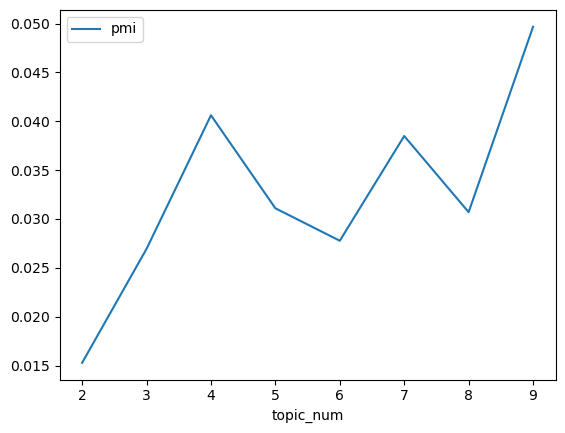

In [ ]:
result.plot.line(x='topic_num', y='pmi')

## 視覺化呈現

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2024-05-01 12:22:26,405 : INFO : using symmetric alpha at 0.125
2024-05-01 12:22:26,406 : INFO : using symmetric eta at 0.125
2024-05-01 12:22:26,409 : INFO : using serial LDA version on this node
2024-05-01 12:22:26,419 : INFO : running online (multi-pass) LDA training, 8 topics, 5 passes over the supplied corpus of 7061 documents, updating model once every 2000 documents, evaluating perplexity every 7061 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-01 12:22:26,420 : INFO : PROGRESS: pass 0, at document #2000/7061
2024-05-01 12:22:27,202 : INFO : merging changes from 2000 documents into a model of 7061 documents
2024-05-01 12:22:27,209 : INFO : topic #6 (0.125): 0.008*"國民黨" + 0.008*"韓國" + 0.007*"台灣" + 0.007*"柯文" + 0.007*"院長" + 0.007*"表示" + 0.006*"民進黨" + 0.006*"立法院" + 0.006*"立委" + 0.005*"政府"
2024-05-01 12:22:27,210 : INFO : topic #3 (0.125): 0.009*"國民黨" + 0.009*"立委" + 0.008*"台灣" + 0.007*"中國" + 0.006*"表示" + 0.006*"立法院" + 0.005*"黨團" + 0.004*"民進黨" + 0.004*"黃國"

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.052084 -0.011521       1        1  23.789630
7      0.123751  0.154774       2        1  13.850017
5     -0.141051  0.085688       3        1  11.373909
3      0.043073 -0.196290       4        1  10.751197
0      0.175207  0.081651       5        1  10.623744
6     -0.129738 -0.021038       6        1  10.409972
1     -0.140420  0.018870       7        1  10.328202
4      0.121264 -0.112134       8        1   8.873329, topic_info=     Term         Freq        Total Category  logprob  loglift
10     台灣  6998.000000  6998.000000  Default  30.0000  30.0000
3254   大陸  3141.000000  3141.000000  Default  29.0000  29.0000
15    國民黨  9061.000000  9061.000000  Default  28.0000  28.0000
288    柯文  4116.000000  4116.000000  Default  27.0000  27.0000
88     院長  5098.000000  5098.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
898    造成   282.626094  1073.107535   Topic8  -5.9554   1.0879
227    進入   266.083281   917.742066   Topic8  -6.0157   1.1840
142    認為   291.018288  3072.708387   Topic8  -5.9261   0.0652
937    政策   266.763094  1264.742452   Topic8  -6.0131   0.8659
364    進行   262.236509  2740.905402   Topic8  -6.0303   0.0753

[653 rows x 6 columns], token_table=      Topic      Freq Term
term                      
6951      4  0.978828   一中
751       1  0.335134   一定
751       2  0.081105   一定
751       3  0.141297   一定
751       4  0.089267   一定
...     ...       ...  ...
4084      1  0.043321   黨部
4084      3  0.953053   黨部
4084      4  0.002407   黨部
4084      7  0.001203   黨部
3605      7  0.993999   龍年

[1932 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 6, 4, 1, 7, 2, 5])

In [ ]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2024-05-01 12:22:56,678 : INFO : using symmetric alpha at 0.2
2024-05-01 12:22:56,679 : INFO : using symmetric eta at 0.2
2024-05-01 12:22:56,682 : INFO : using serial LDA version on this node
2024-05-01 12:22:56,690 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 7061 documents, updating model once every 2000 documents, evaluating perplexity every 7061 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-01 12:22:56,691 : INFO : PROGRESS: pass 0, at document #2000/7061
2024-05-01 12:22:57,455 : INFO : merging changes from 2000 documents into a model of 7061 documents
2024-05-01 12:22:57,459 : INFO : topic #0 (0.200): 0.011*"表示" + 0.010*"民進黨" + 0.007*"立委" + 0.007*"民眾" + 0.007*"國民黨" + 0.006*"台灣" + 0.006*"立法院" + 0.006*"今天" + 0.006*"黨團" + 0.004*"政府"
2024-05-01 12:22:57,460 : INFO : topic #1 (0.200): 0.010*"立委" + 0.010*"民進黨" + 0.008*"表示" + 0.007*"台灣" + 0.006*"質詢" + 0.006*"立法院" + 0.006*"國民黨" + 0.005*"韓國" + 0.005*"總統" + 0

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.111654 -0.120650       1        1  28.984744
1      0.143919  0.001745       2        1  18.929929
4     -0.118719 -0.089561       3        1  18.528588
3      0.019883  0.199648       4        1  16.975077
0     -0.156736  0.008819       5        1  16.581662, topic_info=     Term         Freq        Total Category  logprob  loglift
10     台灣  6964.000000  6964.000000  Default  30.0000  30.0000
3254   大陸  3287.000000  3287.000000  Default  29.0000  29.0000
88     院長  4992.000000  4992.000000  Default  28.0000  28.0000
90     韓國  4766.000000  4766.000000  Default  27.0000  27.0000
332    黨團  3437.000000  3437.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
715    要求   461.337014  1828.092539   Topic5  -6.0906   0.4200
953    現在   508.294127  3238.341672   Topic5  -5.9937  -0.0549
3254   大陸   495.576652  3287.485247   Topic5  -6.0190  -0.0953
60     立委   559.450261  9820.895325   Topic5  -5.8978  -1.0684
1441   應該   465.122082  2408.897493   Topic5  -6.0825   0.1522

[411 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.160617   一起
0         2  0.570291   一起
0         3  0.121987   一起
0         4  0.091490   一起
0         5  0.054894   一起
...     ...       ...  ...
4084      1  0.290398   黨部
4084      2  0.649329   黨部
4084      3  0.012777   黨部
4084      4  0.047625   黨部
3605      2  0.994893   龍年

[988 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 4, 1])

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

In [ ]:
import guidedlda

In [ ]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一起', '一路', '並稱', '付出', '使用', '兩位', '出任', '出爐', '創造', '努力')

In [ ]:
word2id = dictionary.token2id

In [ ]:
seed_topic_list = [
    ["台灣", "中國", "大陸", "美國", "兩岸"],
    ["總統", "民進黨", "國民黨", "立委"],
    ["立法院", "院長", "民進黨", "國民黨", "立委"],
    ["市長", "市府", "中央", "地方"],
    ["調查", "事件", "問題"]
]

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-01 12:30:00,165 : INFO : n_documents: 7061
2024-05-01 12:30:00,165 : INFO : vocab_size: 18998
2024-05-01 12:30:00,166 : INFO : n_words: 1228901
2024-05-01 12:30:00,166 : INFO : n_topics: 6
2024-05-01 12:30:00,166 : INFO : n_iter: 100
2024-05-01 12:30:04,574 : INFO : <0> log likelihood: -12936470
2024-05-01 12:30:05,387 : INFO : <20> log likelihood: -10488447
2024-05-01 12:30:06,178 : INFO : <40> log likelihood: -10407622
2024-05-01 12:30:06,965 : INFO : <60> log likelihood: -10371548
2024-05-01 12:30:07,743 : INFO : <80> log likelihood: -10356117
2024-05-01 12:30:08,519 : INFO : <99> log likelihood: -10345007


In [ ]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 台灣 大陸 中國 海巡 表示 美國 兩岸 金門 指出 管碧玲
Topic 1: 總統 台灣 表示 賴清德 英文 未來 希望 主席 今天 議員
Topic 2: 民進黨 國民黨 立委 立法院 韓國 院長 民眾 黨團 柯文 表示
Topic 3: 市長 市府 萬安 表示 台北市 議員 地方 中央 台北 政府
Topic 4: 事件 政府 表示 調查 食安 問題 發生 衛福部 台中市 相關
Topic 5: 政府 電價 台灣 表示 相關 指出 政策 提出 陳建仁 行政院


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.037710  0.159776       1        1  30.970858
1     -0.268512 -0.076482       2        1  16.789638
0     -0.051120  0.104819       3        1  15.877213
4      0.165301  0.135091       4        1  12.427701
5      0.121049 -0.170580       5        1  12.316539
3      0.070992 -0.152624       6        1  11.618051, topic_info=     Term         Freq        Total Category  logprob  loglift
194    市長  3931.000000  3931.000000  Default  30.0000  30.0000
90     韓國  4920.000000  4920.000000  Default  29.0000  29.0000
3254   大陸  3029.000000  3029.000000  Default  28.0000  28.0000
15    國民黨  8988.000000  8988.000000  Default  27.0000  27.0000
10     台灣  7204.000000  7204.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
1353   預算   452.485053   958.094734   Topic6  -5.7543   1.4024
124    民眾   587.328615  5768.516043   Topic6  -5.4934  -0.1320
301    相關   514.413207  2912.024296   Topic6  -5.6260   0.4190
981    針對   467.467671  2642.562346   Topic6  -5.7217   0.4204
1222   指出   462.473465  4329.930634   Topic6  -5.7324  -0.0841

[448 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.140063   一起
0         2  0.641958   一起
0         3  0.042797   一起
0         4  0.099212   一起
0         5  0.005836   一起
...     ...       ...  ...
332       3  0.003723   黨團
4084      1  0.211778   黨部
4084      2  0.786602   黨部
4084      6  0.001210   黨部
3605      2  1.000490   龍年

[896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 6, 4])

In [ ]:
seed_topic_list = [
    ["台灣", "中國", "大陸", "美國"],
    ["總統"],
    ["立法院", "院長", "立委"],
    ["市長", "市府", "中央", "地方"],
    ["調查", "事件", "問題"],
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-01 12:32:04,460 : INFO : n_documents: 7061
2024-05-01 12:32:04,461 : INFO : vocab_size: 18998
2024-05-01 12:32:04,461 : INFO : n_words: 1228901
2024-05-01 12:32:04,462 : INFO : n_topics: 6
2024-05-01 12:32:04,463 : INFO : n_iter: 100
2024-05-01 12:32:08,873 : INFO : <0> log likelihood: -12975934
2024-05-01 12:32:09,694 : INFO : <20> log likelihood: -10506187
2024-05-01 12:32:10,509 : INFO : <40> log likelihood: -10423416
2024-05-01 12:32:11,334 : INFO : <60> log likelihood: -10386608
2024-05-01 12:32:12,136 : INFO : <80> log likelihood: -10369062
2024-05-01 12:32:12,934 : INFO : <99> log likelihood: -10356131


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 台灣 大陸 海巡 中國 表示 美國 兩岸 金門 指出 管碧玲
Topic 1: 總統 台灣 賴清德 表示 英文 未來 主席 希望 民進黨 國民黨
Topic 2: 民進黨 國民黨 立委 立法院 韓國 院長 民眾 黨團 柯文 表示
Topic 3: 市長 市府 萬安 表示 台北市 議員 地方 台北 中央 政府
Topic 4: 事件 政府 表示 調查 食安 發生 問題 相關 衛福部 台中市
Topic 5: 政府 電價 台灣 表示 相關 指出 政策 提出 陳建仁 數位


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.063057  0.151118       1        1  29.484876
1      0.262321 -0.077166       2        1  17.092120
0      0.030313  0.104342       3        1  16.166396
4     -0.161222  0.138360       4        1  13.247537
5     -0.118659 -0.136558       5        1  12.193842
3     -0.075810 -0.180096       6        1  11.815228, topic_info=     Term         Freq        Total Category  logprob  loglift
194    市長  3931.000000  3931.000000  Default  30.0000  30.0000
90     韓國  4920.000000  4920.000000  Default  29.0000  29.0000
3254   大陸  3029.000000  3029.000000  Default  28.0000  28.0000
332    黨團  4029.000000  4029.000000  Default  27.0000  27.0000
62    立法院  5649.000000  5649.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
124    民眾   595.327252  5768.439117   Topic6  -5.4967  -0.1353
301    相關   516.417749  2912.055109   Topic6  -5.6389   0.4061
1222   指出   492.445242  4329.942722   Topic6  -5.6865  -0.0381
981    針對   473.467007  2642.578722   Topic6  -5.7258   0.4164
364    進行   468.472734  2841.479914   Topic6  -5.7364   0.3332

[451 rows x 6 columns], token_table=      Topic      Freq Term
term                      
3214      1  1.000333   一席
0         1  0.122555   一起
0         2  0.642929   一起
0         3  0.043770   一起
0         4  0.095321   一起
...     ...       ...  ...
159       5  0.055500  黨立委
4084      1  0.156113   黨部
4084      2  0.816869   黨部
4084      6  0.026624   黨部
3605      2  1.000483   龍年

[882 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 6, 4])

## 7.主題分佈的應用，搭配其他文章資訊

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(0, 0.02388441), (1, 0.16732246), (2, 0.80558586)]

In [ ]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.50913972, 0.48655349, 0.        , 0.        ],
       [0.        , 0.        , 0.99175465, 0.        , 0.        ],
       [0.        , 0.10147048, 0.89390278, 0.        , 0.        ],
       ...,
       [0.        , 0.41076568, 0.        , 0.        , 0.58483446],
       [0.87660098, 0.06346419, 0.        , 0.04280529, 0.01598877],
       [0.        , 0.08128657, 0.        , 0.91575068, 0.        ]])

In [ ]:
df_clean['topic_label'] = m_theta.argmax(axis=1) + 1

In [ ]:
df_clean['topic_label'].value_counts()

topic_label
3    2102
2    1369
5    1242
1    1188
4    1160
Name: count, dtype: int64

In [ ]:
df_clean.head()

,content,artUrl,artDate,words,topic_label
0,立法院第屆新科立委今報到並投票選出立法院正副院長稍早立法院長選舉結果出爐確定由國民黨立委韓國...,https://tw.nextapple.com/politics/20240201/002...,2024-02-01 13:59:00,"[立法院, 第屆, 新科, 立委, 報到, 投票, 選出, 立法院, 正副, 院長, 稍早,...",2
1,立法院長龍頭戰民眾黨立委陳昭姿雖遵循黨意投給黨內立委黃珊珊但印泥不小心沾染到其他立委框格被臨...,https://tw.nextapple.com/politics/20240201/01F...,2024-02-01 16:40:00,"[立法, 院長, 龍頭, 戰民眾, 黨立委, 昭姿, 遵循, 黨意, 投給, 黨內, 立委,...",3
2,第屆立委今天報到民進黨立委黃捷被問到想對國民黨立委韓國瑜說什麼她回應過去就過去了接下來就好好...,https://tw.nextapple.com/politics/20240201/084...,2024-02-01 10:12:00,"[第屆, 立委, 今天, 報到, 民進黨, 立委, 問到, 國民黨, 立委, 韓國, 回應,...",3
3,立法院正副院長選舉落幕掌握八席的民眾黨在上午院長下午副院長選舉採取相同策略第一輪分別投黨內立...,https://tw.nextapple.com/politics/20240201/0D6...,2024-02-01 18:12:00,"[立法院, 正副, 院長, 選舉, 落幕, 掌握, 八席, 民眾, 上午, 院長, 下午, ...",3
4,立法院第屆新科立委今天正式報到宣誓並進行立法院正副院長選舉院長選舉確定由國民黨立委韓國瑜以票...,https://tw.nextapple.com/politics/20240201/11A...,2024-02-01 17:09:00,"[立法院, 第屆, 新科, 立委, 今天, 正式, 報到, 宣誓, 進行, 立法院, 正副,...",3


In [ ]:
df_clean['artDate'] = pd.to_datetime(df_clean['artDate'])

In [ ]:
df_clean['artDate'].dt.date

0       2024-02-01
1       2024-02-01
2       2024-02-01
3       2024-02-01
4       2024-02-01
           ...    
7056    2024-04-01
7057    2024-04-01
7058    2024-04-01
7059    2024-04-01
7060    2024-04-01
Name: artDate, Length: 7061, dtype: object

In [ ]:
df_clean.groupby(df_clean['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-02-01  3              0.663415
            2              0.214634
            5              0.053659
            4              0.043902
            1              0.024390
                             ...   
2024-04-01  5              0.346457
            1              0.188976
            3              0.165354
            4              0.149606
            2              0.149606
Name: proportion, Length: 302, dtype: float64

In [ ]:
date_topic = df_clean.groupby(df_clean['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5
artDate,,,,,
2024-02-01,0.024390,0.214634,0.663415,0.043902,0.053659
2024-02-02,0.015152,0.121212,0.780303,0.045455,0.037879
2024-02-03,0.040404,0.111111,0.727273,0.010101,0.111111
2024-02-04,0.065421,0.214953,0.504673,0.046729,0.168224
2024-02-05,0.094488,0.141732,0.488189,0.023622,0.251969


2024-05-01 12:35:20,080 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:35:20,081 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:35:20,082 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:35:20,083 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:35:20,084 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:35:20,085 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-01 12:35:20,086 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

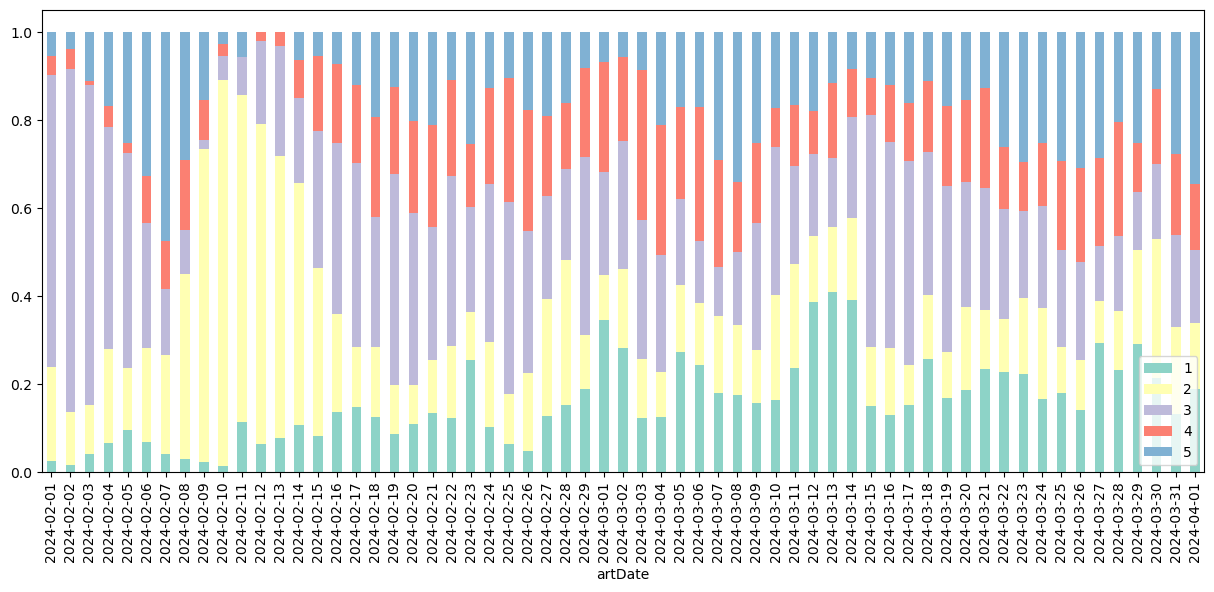

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')